# Tarea 3: Análisis de Datos - Series Temporales

## Referencia de Datos

[Datos de Temperatura DMC 2023](https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/refs/heads/main/output/temperatura_dmc/2023/2023_temperatura_dmc.csv)

Para la tercera tarea, utilizaremos datos del repositorio del [Ministerio de Ciencia](https://github.com/MinCiencia/Datos-CambioClimatico), particularmente datos de Temperatura de Meteo Chile.

In [1]:
# Importaciones de análisis de datos
import pandas as pd
import numpy as np

# Importaciones de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Importaciones de Statsmodels para series temporales
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Importaciones de scikit-learn para machine learning
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay

# Otras herramientas
import joblib
import warnings

# Configuración de warnings y visualización (manejo de errores)
warnings.filterwarnings("ignore")
%matplotlib notebook
%matplotlib inline


In [2]:
url = 'https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/refs/heads/main/output/temperatura_dmc/2023/2023_temperatura_dmc.csv'
df = pd.read_csv(url)
df.head()

,time,latitud,longitud,Ts_Valor,CodigoNacional,nombreEstacion
0,2023-01-01 01:00:00,-18.35555,-70.34028,20.0,180005.0,"Chacalluta, Arica Ap."
1,2023-01-01 02:00:00,-18.35555,-70.34028,20.3,180005.0,"Chacalluta, Arica Ap."
2,2023-01-01 03:00:00,-18.35555,-70.34028,20.5,180005.0,"Chacalluta, Arica Ap."
3,2023-01-01 04:00:00,-18.35555,-70.34028,20.4,180005.0,"Chacalluta, Arica Ap."
4,2023-01-01 05:00:00,-18.35555,-70.34028,19.8,180005.0,"Chacalluta, Arica Ap."


EL repositorio cuenta con datos de temperatura desde 1950 a 2023, en el ejemplo se muestra la base de datos del 2023 que considera lol siguiente:
- **time**: estampa de tiempo de intervalo 1 hora.
- **latitud**: latitud de la estación meteorológica que toma la medición.
- **longitud**: longitud de la estación meteorológica que toma la medición.
- **Ts_Valor**: valor de temperatura registrada en el tiempo **time**.
- **CodigoNacional**: código numerico que se asigna a cada una de las 49 estaciones que contiene el dataset.
- **nombreEstacion**: nombre de cada estación de monitoreo.

### Descripción de la variable `Ts_Valor`

Este análisis utiliza datos de temperatura horaria de la Dirección Meteorológica de Chile (DMC). La columna `Ts_Valor` es la variable dependiente, que representa la **temperatura ambiente** en grados Celsius.

#### Contexto e importancia de `Ts_Valor`

La temperatura es una variable crucial para entender los patrones climáticos y realizar predicciones meteorológicas. En este dataset, es esperable encontrar **estacionalidad** (variaciones diarias y anuales) y **tendencias** a largo plazo, lo cual requiere un análisis detallado.

#### Desafíos del análisis

- **No estacionariedad**: Las fluctuaciones y tendencias en la temperatura pueden requerir transformaciones (como diferenciación) para estabilizar la serie temporal.
- **Estacionalidad**: Modelar las variaciones estacionales (diarias y anuales) es esencial para mejorar la precisión de las predicciones.

#### Objetivo del análisis

El objetivo es modelar la temperatura a lo largo del tiempo usando modelos autoregresivos (AR), aplicando transformaciones necesarias para manejar estacionalidad y tendencias, con el fin de generar predicciones precisas.

#### Consideraciones

Para efectos de este análisis se considera la temperatura registrada en la estación ***Quinta Normal, Santiago*** entre los años ***2018*** y ***2023***.


In [3]:
def getVarDMC_y(url: str, est: str, y_i: int, y_e: int) -> pd.DataFrame:
    var = url.split('/')[-2]
    data_frames = []
    for y in range(y_i, y_e + 1):
        url_ = f'{url}{y}/{y}_{var}.csv'
        try:
            df = pd.read_csv(url_)
            df = df[df['nombreEstacion'] == est]
            data_frames.append(df)
        except Exception as e:
            print(f"Error reading {url_}: {e}")
    if not data_frames:
        raise ValueError("No data frames were loaded. Check the URL and parameters.")
    df = pd.concat(data_frames, ignore_index=True)
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
    df['CodigoNacional'] = df['CodigoNacional'].astype(str)
    return df

In [4]:
estacion = 'Quinta Normal, Santiago'
year_ini = 2018
year_end = 2023

df_temp = getVarDMC_y('https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/refs/heads/main/output/temperatura_dmc/', estacion, year_ini, year_end)

In [5]:
df_temp.describe()

,time,latitud,longitud,Ts_Valor
count,50290,5.029000e+04,5.029000e+04,50287.000000
mean,2020-11-14 14:43:43.583217152,-3.344500e+01,-7.068278e+01,15.367312
min,2018-01-01 01:00:00,-3.344500e+01,-7.068278e+01,-2.300000
25%,2019-06-09 04:15:00,-3.344500e+01,-7.068278e+01,9.700000
50%,2020-11-14 16:30:00,-3.344500e+01,-7.068278e+01,14.400000
75%,2022-04-22 17:45:00,-3.344500e+01,-7.068278e+01,20.600000
max,2023-09-29 07:00:00,-3.344500e+01,-7.068278e+01,38.000000
std,NaN,7.105498e-15,1.421100e-14,7.507674


In [6]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50290 entries, 0 to 50289
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            50290 non-null  datetime64[ns]
 1   latitud         50290 non-null  float64       
 2   longitud        50290 non-null  float64       
 3   Ts_Valor        50287 non-null  float64       
 4   CodigoNacional  50290 non-null  object        
 5   nombreEstacion  50290 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 2.3+ MB


La columna **Ts_Valor** posee 3 valores perdidos, en este caso serán imputados utilizando una media móvil de ventana 5 centrada en el valor actual, o sea, al encontrar un valor perdido tomará los 2 registros anteriores y los 2 registros posteriores para calcular el promedio.

In [7]:
df_temp['Ts_Valor'] = df_temp['Ts_Valor'].fillna(df_temp['Ts_Valor'].rolling(window=5, min_periods=1, center=True).mean())

In [8]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50290 entries, 0 to 50289
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            50290 non-null  datetime64[ns]
 1   latitud         50290 non-null  float64       
 2   longitud        50290 non-null  float64       
 3   Ts_Valor        50290 non-null  float64       
 4   CodigoNacional  50290 non-null  object        
 5   nombreEstacion  50290 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 2.3+ MB


### Test de Estacionariedad - Dickey-Fuller Aumentado (ADF)

El **Test de Dickey-Fuller Aumentado (ADF)** es una herramienta clave en el análisis de series temporales que nos permite evaluar la **estacionariedad** de una serie, es decir, si sus propiedades estadísticas, como la media y la varianza, se mantienen constantes a lo largo del tiempo.

Este test tiene como objetivo verificar la presencia de una **raíz unitaria**, lo cual indicaría que la serie es **no estacionaria**. La **hipótesis nula (H₀)** del test ADF sostiene que la serie contiene una raíz unitaria, es decir, **no es estacionaria**. Si el **p-value** resultante es menor que un nivel de significancia predefinido (usualmente 0.05), podemos rechazar la hipótesis nula y concluir que la serie es **estacionaria**.

El ADF extiende el test original de Dickey-Fuller al considerar **autocorrelaciones** en los residuos, haciéndolo más robusto y efectivo para series temporales con dinámicas complejas. En el contexto de este análisis, la estacionariedad es crucial, ya que una serie no estacionaria podría generar predicciones sesgadas y no confiables. Si la serie no es estacionaria, se pueden aplicar transformaciones, como la diferenciación, para corregir este comportamiento antes de proceder con el modelado.


In [9]:
def test_stationarity(serie: pd.Series) -> None:
    result = adfuller(serie, autolag='AIC')
    print('Estadístico ADF:', result[0])
    print('p-value:', result[1])
    print('Número de lags usados:', result[2])
    print('Número de observaciones:', result[3])
    print('Valores críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print("La serie es estacionaria (rechazamos la hipótesis nula de no estacionariedad).")
    else:
        print("La serie no es estacionaria (no podemos rechazar la hipótesis nula de no estacionariedad).")

serie = df_temp[df_temp.time.dt.year<2023]['Ts_Valor'] # 2023 será para test
test_stationarity(serie)

Estadístico ADF: -6.7142692832819675
p-value: 3.615184944610602e-09
Número de lags usados: 52
Número de observaciones: 43725
Valores críticos:
   1%: -3.430499563955195
   5%: -2.8616061039874996
   10%: -2.5668051850026856
La serie es estacionaria (rechazamos la hipótesis nula de no estacionariedad).


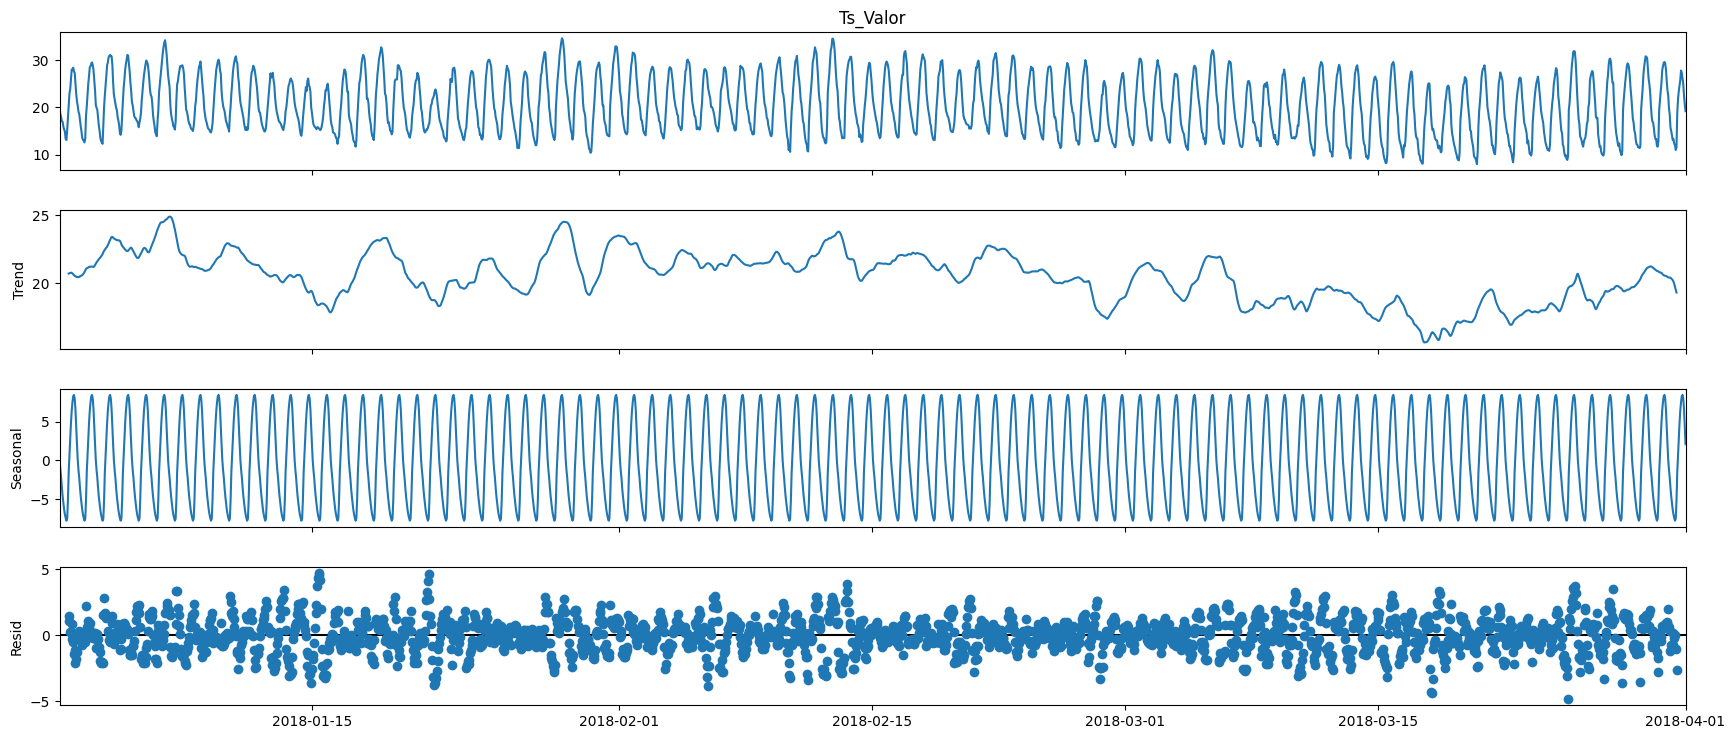

In [10]:
decomposition = seasonal_decompose(df_temp[df_temp.time.dt.year<2023][:(24*30*3)].set_index('time')['Ts_Valor'], model='additive', period=24)

# Graficar la descomposición
fig = decomposition.plot()
fig.set_size_inches(20, 8)
plt.show()


<Axes: xlabel='time'>

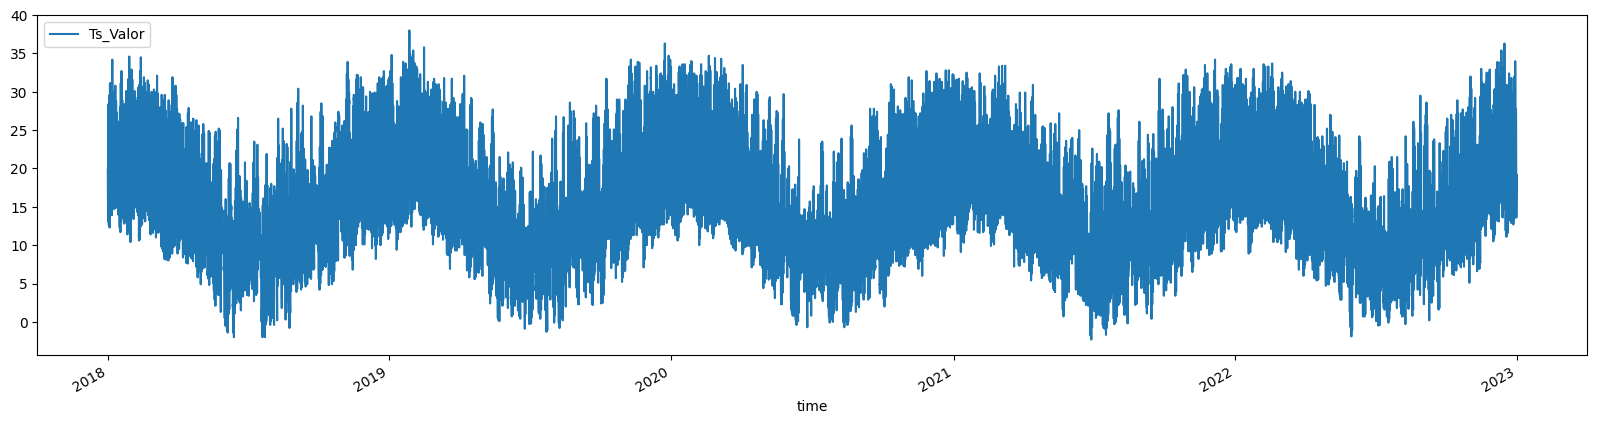

In [11]:
# 6 años
df_temp[df_temp.time.dt.year<2023][['time', 'Ts_Valor']].plot(x='time', y='Ts_Valor', figsize=(20,5))

<Axes: xlabel='time'>

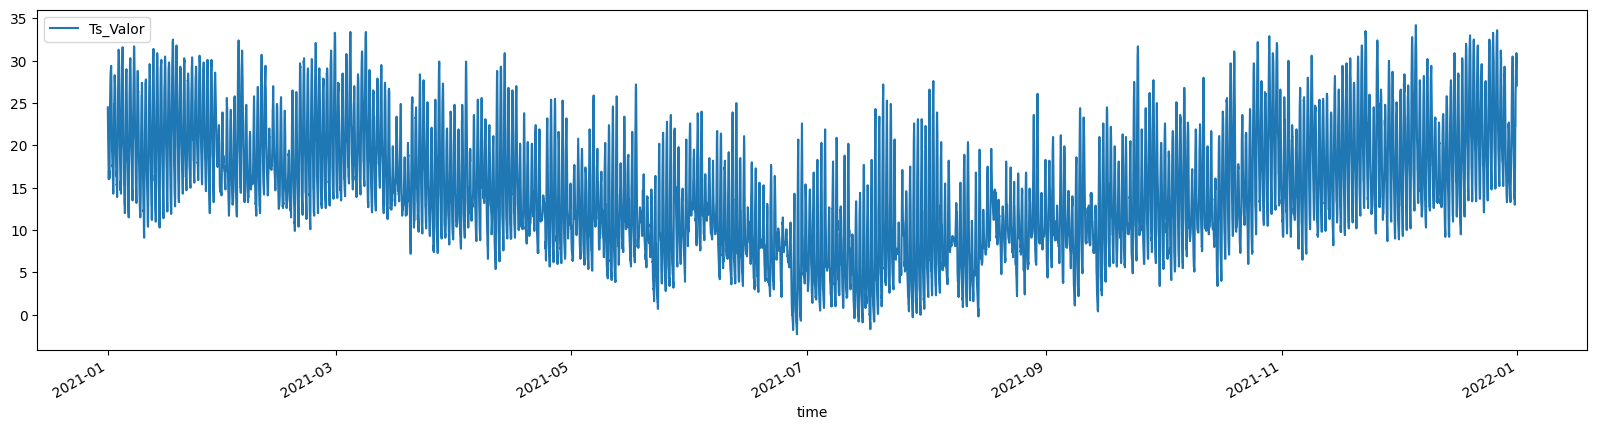

In [12]:
# 1 año
df_temp[df_temp.time.dt.year<2023][df_temp.time.dt.year<2023][(df_temp['time'] >= '2021-01-01') & (df_temp['time'] < '2022-01-01')].plot(x='time', y='Ts_Valor', figsize=(20,5))

<Axes: xlabel='time'>

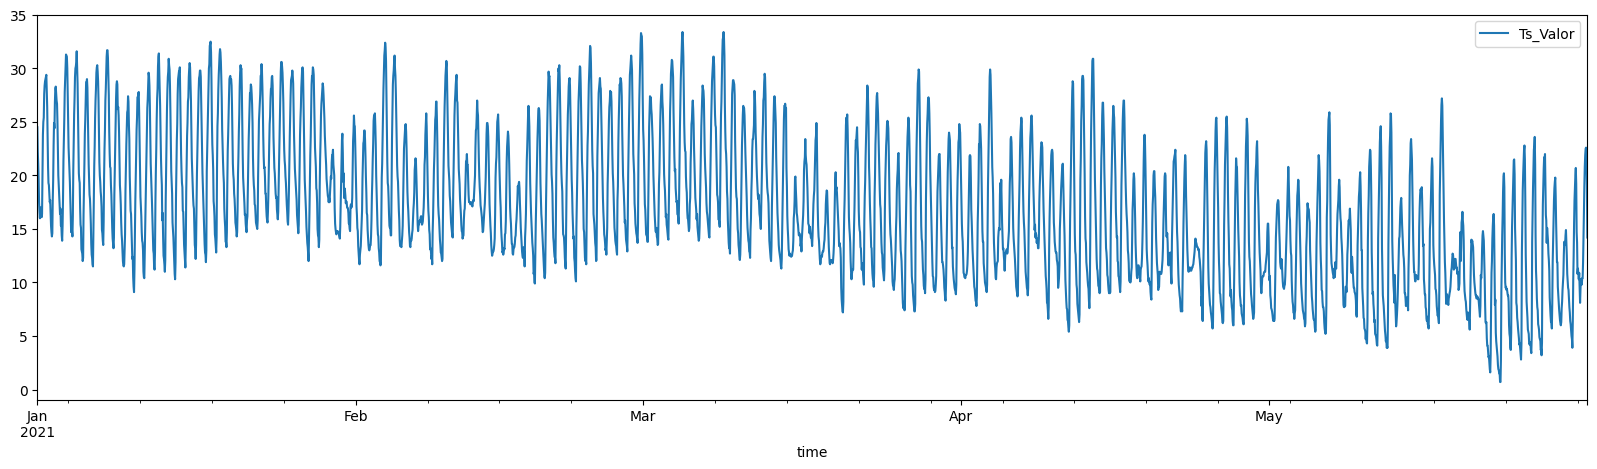

In [13]:
# 6 meses
df_temp[df_temp.time.dt.year<2023][(df_temp['time'] >= '2021-01-01') & (df_temp['time'] < '2021-06-01')].plot(x='time', y='Ts_Valor', figsize=(20,5))

<Axes: xlabel='time'>

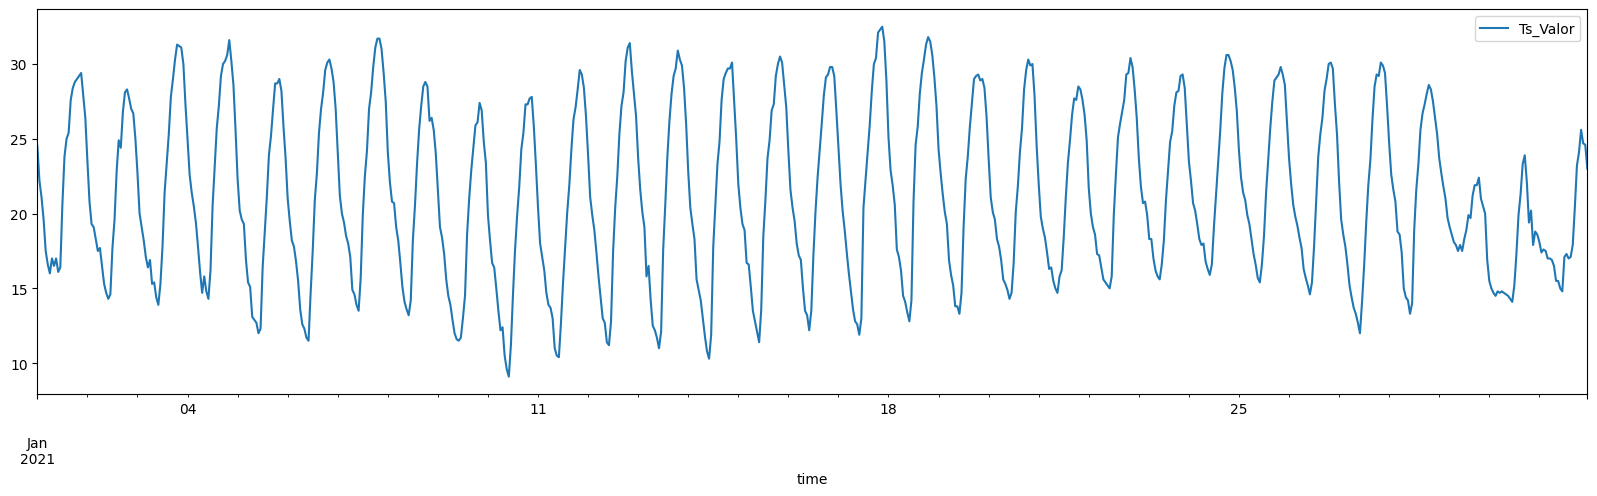

In [14]:
# 1 mes
df_temp[df_temp.time.dt.year<2023][(df_temp['time'] >= '2021-01-01') & (df_temp['time'] < '2021-02-01')].plot(x='time', y='Ts_Valor', figsize=(20,5))

<Axes: xlabel='time'>

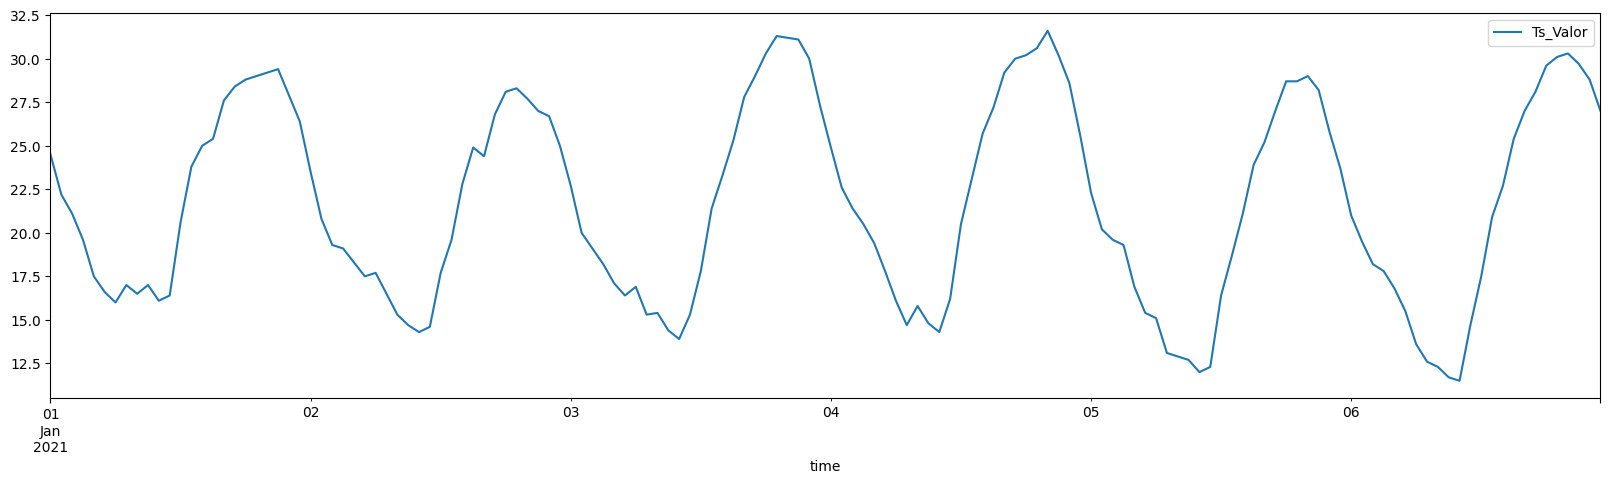

In [15]:
# 1 semana
df_temp[df_temp.time.dt.year<2023][(df_temp['time'] >= '2021-01-01') & (df_temp['time'] < '2021-01-07')].plot(x='time', y='Ts_Valor', figsize=(20,5))

<Axes: xlabel='time'>

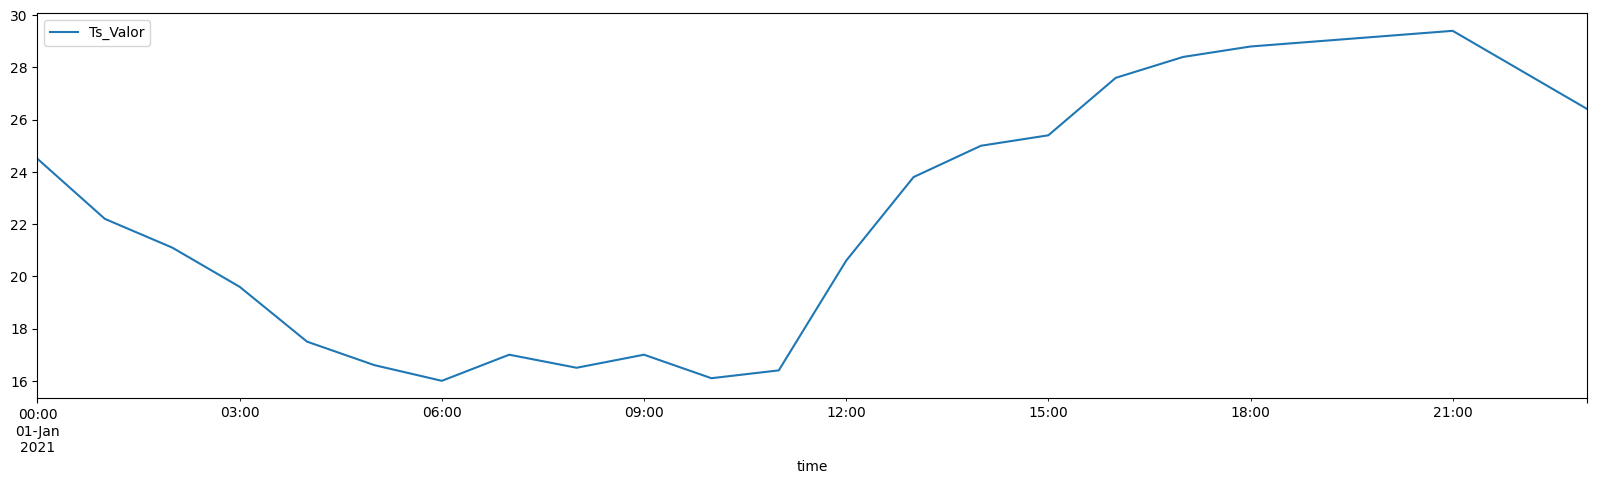

In [16]:
# 1 dia
df_temp[df_temp.time.dt.year<2023][df_temp.time.dt.date == pd.to_datetime('2021-01-01').date()].plot(x='time', y='Ts_Valor', figsize=(20,5))

### Auto Correlación (ACF) y Auto Correlación Parcial (PACF)

La autocorrelación mide la correlación entre una serie temporal y una versión desplazada de sí misma (un "lag" o retraso). En otras palabras, indica qué tan bien están correlacionados los valores de una serie con sus propios valores en puntos anteriores. Es útil para identificar patrones de repetición o estacionalidad en los datos, pero puede incluir influencias indirectas (efectos en cadena de lags anteriores).

La autocorrelación parcial mide la correlación directa entre una serie temporal y una versión desplazada de sí misma, eliminando el efecto de los lags intermedios. Es útil para identificar el número adecuado de lags (orden) en modelos autoregresivos (AR), ya que te ayuda a determinar hasta qué lag hay una relación significativa directa.

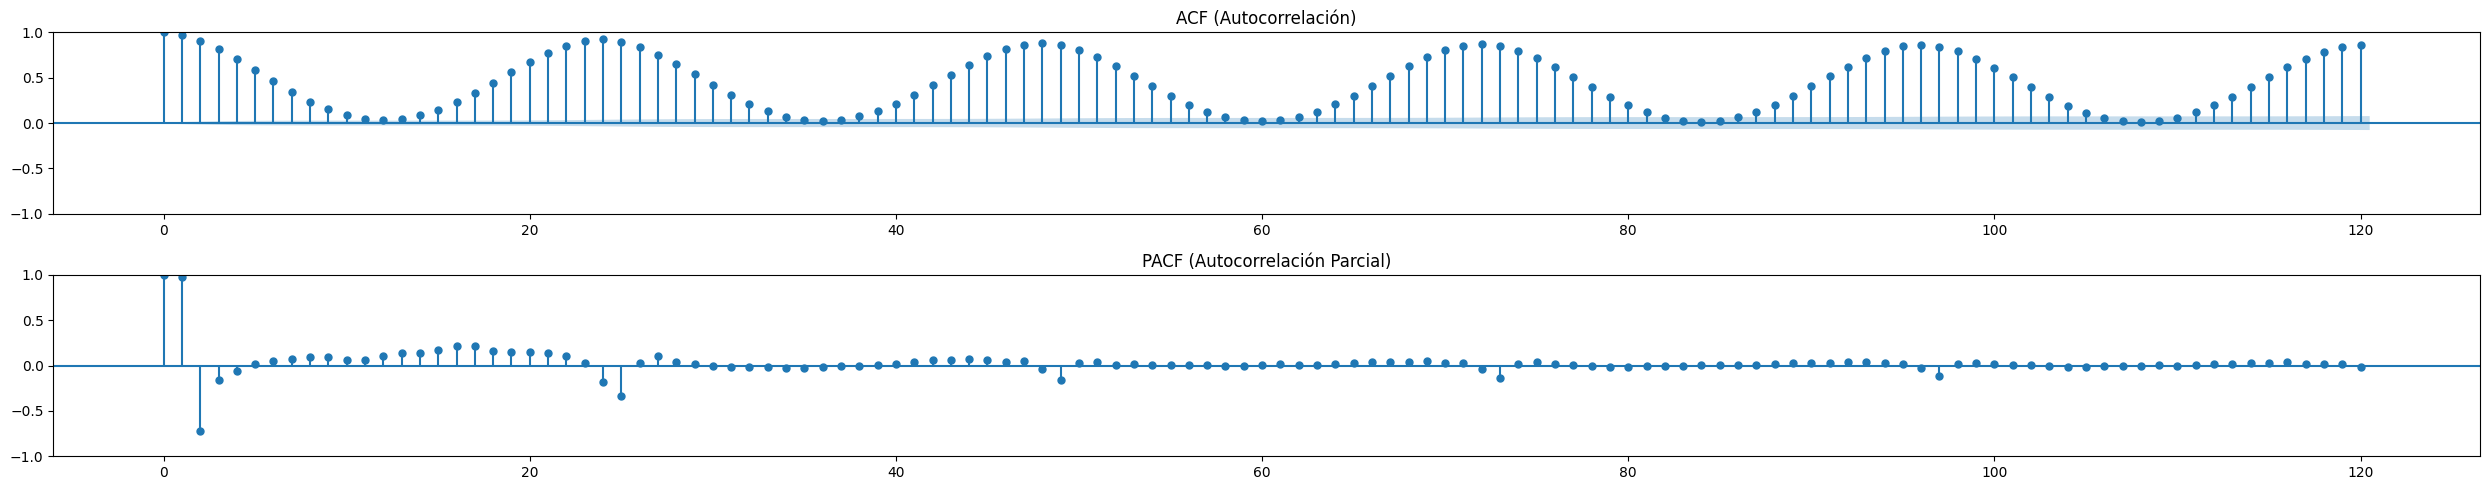

In [17]:
# Configuración de la figura y los ejes
fig, axes = plt.subplots(2, 1, figsize=(25, 5))

# Definición del número de días
n_dias = 5

# Filtrado de datos
df_filtrado = df_temp[df_temp.time.dt.year < 2023][['time', 'Ts_Valor']].set_index('time')

# Gráfico de ACF
plot_acf(df_filtrado, lags=24 * n_dias, ax=axes[0])
axes[0].set_title("ACF (Autocorrelación)")

# Gráfico de PACF
plot_pacf(df_filtrado, lags=24 * n_dias, ax=axes[1])
axes[1].set_title("PACF (Autocorrelación Parcial)")

plt.tight_layout()
# Mostrar los gráficos
plt.show()

### Modelos Autoregresivos (AR)

#### Modelos con Regresiones lineales simples

In [18]:
def create_lagged_features(df: pd.DataFrame, column: str, lags: list) -> pd.DataFrame:
    df_lagged = df[['time', column]].copy()
    for lag in lags:
        df_lagged[f'{column}_{lag}h'] = np.nan
        df_lagged[f'{column}_{lag}h'].iloc[: -lag] = df_lagged[column].iloc[lag:]
    return df_lagged

#Creamos data set de entrenamientos y test con los lags
df_temp_ = create_lagged_features(df_temp, 'Ts_Valor', [1,2,3,24,25]) # lags determinados a partir del PACF
df_temp_train = df_temp_[df_temp_.time.dt.year<2023].dropna()
df_temp_test = df_temp_[df_temp_.time.dt.year==2023].dropna()


In [19]:
df_temp_train.describe()

,time,Ts_Valor,Ts_Valor_1h,Ts_Valor_2h,Ts_Valor_3h,Ts_Valor_24h,Ts_Valor_25h
count,43778,43778.000000,43778.000000,43778.000000,43778.000000,43778.000000,43778.000000
mean,2020-07-01 19:11:34.047238144,15.353149,15.353104,15.353063,15.353026,15.352985,15.353090
min,2018-01-01 01:00:00,-2.300000,-2.300000,-2.300000,-2.300000,-2.300000,-2.300000
25%,2019-04-02 08:15:00,9.600000,9.600000,9.600000,9.600000,9.600000,9.600000
50%,2020-07-02 00:30:00,14.500000,14.500000,14.500000,14.500000,14.500000,14.500000
75%,2021-10-01 05:45:00,20.700000,20.700000,20.700000,20.700000,20.700000,20.700000
max,2022-12-31 23:00:00,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
std,NaN,7.547061,7.547040,7.547028,7.547019,7.547330,7.547431


In [20]:
df_temp_test.describe()

,time,Ts_Valor,Ts_Valor_1h,Ts_Valor_2h,Ts_Valor_3h,Ts_Valor_24h,Ts_Valor_25h
count,6487,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000
mean,2023-05-16 03:00:00,15.474210,15.472530,15.470865,15.469231,15.444443,15.441683
min,2023-01-01 00:00:00,-1.100000,-1.100000,-1.100000,-1.100000,-1.100000,-1.100000
25%,2023-03-09 13:30:00,10.200000,10.200000,10.200000,10.200000,10.200000,10.200000
50%,2023-05-16 03:00:00,14.100000,14.100000,14.100000,14.100000,14.100000,14.100000
75%,2023-07-22 16:30:00,19.900000,19.900000,19.900000,19.900000,19.900000,19.900000
max,2023-09-28 06:00:00,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
std,NaN,7.240653,7.241378,7.242337,7.243346,7.234616,7.234422


In [21]:
def ar_model_(X: pd.Series, y: pd.Series) -> tuple[float, float, object]:
    X = pd.DataFrame({'y_lagged': X}).dropna()
    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)
    r2 = model.score(X, y)
    mse = mean_squared_error(y, y_pred)
    return r2, mse, model

results = []
models = []
for i in [1,2,3,24,25]:
    r2, mse, model = ar_model_(df_temp_train['Ts_Valor'], df_temp_train[f'Ts_Valor_{i}h'])
    n = len(df_temp_train['Ts_Valor'])
    p = 1
    r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    results.append((i, r2, r2_adjusted, mse))
    models.append((i, model))

results_df = pd.DataFrame(results, columns=['Order', 'R²', 'R² Adjust', 'MSE'])

# Resultados del conjunto de entrenamiento
results_df.style.set_caption("AR Model Performance - Train").background_gradient(cmap='coolwarm').format(precision=4)

,Order,R²,R² Adjust,MSE
0,1,0.9474,0.9474,2.9954
1,2,0.8275,0.8274,9.8278
2,3,0.6694,0.6694,18.8309
3,24,0.8523,0.8523,8.4142
4,25,0.8079,0.8079,10.9414


In [22]:
# Coeficientes de los modelos lineales simples por separado
for m in models:
    print(f'modelo con lag {m[0]}')
    print(f'Intercepto: {np.round(m[1].intercept_,4)}\nCoeficientes: {[np.round(c,4) for c in m[1].coef_]}')
    print()

modelo con lag 1
Intercepto: 0.4092
Coeficientes: [np.float64(0.9733)]

modelo con lag 2
Intercepto: 1.3872
Coeficientes: [np.float64(0.9096)]

modelo con lag 3
Intercepto: 2.7918
Coeficientes: [np.float64(0.8182)]

modelo con lag 24
Intercepto: 1.1786
Coeficientes: [np.float64(0.9232)]

modelo con lag 25
Intercepto: 1.5523
Coeficientes: [np.float64(0.8989)]



In [23]:
def calculate_test_metrics(models: list, df_temp_test: pd.DataFrame) -> pd.DataFrame:

    results = []

    for order, model in models:
        y: pd.Series = df_temp_test['Ts_Valor']
        X: pd.DataFrame = pd.DataFrame({'y_lagged': df_temp_test[f'Ts_Valor_{order}h']})
        y_pred: pd.Series = model.predict(X)
        r2: float = model.score(X, y)
        n: int = len(df_temp_test['Ts_Valor'])
        p: int = 1  # Only one predictor in this case
        r2_adjusted: float = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        mse: float = mean_squared_error(y, y_pred)
        results.append((order, r2, r2_adjusted, mse))
    return pd.DataFrame(results, columns=['Order', 'R²', 'R² Adjust', 'MSE'])
results_df_test: pd.DataFrame = calculate_test_metrics(models, df_temp_test)
results_df_test.style.set_caption("AR Model Performance - Test").background_gradient(cmap='coolwarm').format(precision=4)


,Order,R²,R² Adjust,MSE
0,1,0.9480,0.9480,2.7254
1,2,0.8313,0.8313,8.8409
2,3,0.6776,0.6775,16.9024
3,24,0.8681,0.8681,6.9123
4,25,0.8272,0.8272,9.0562


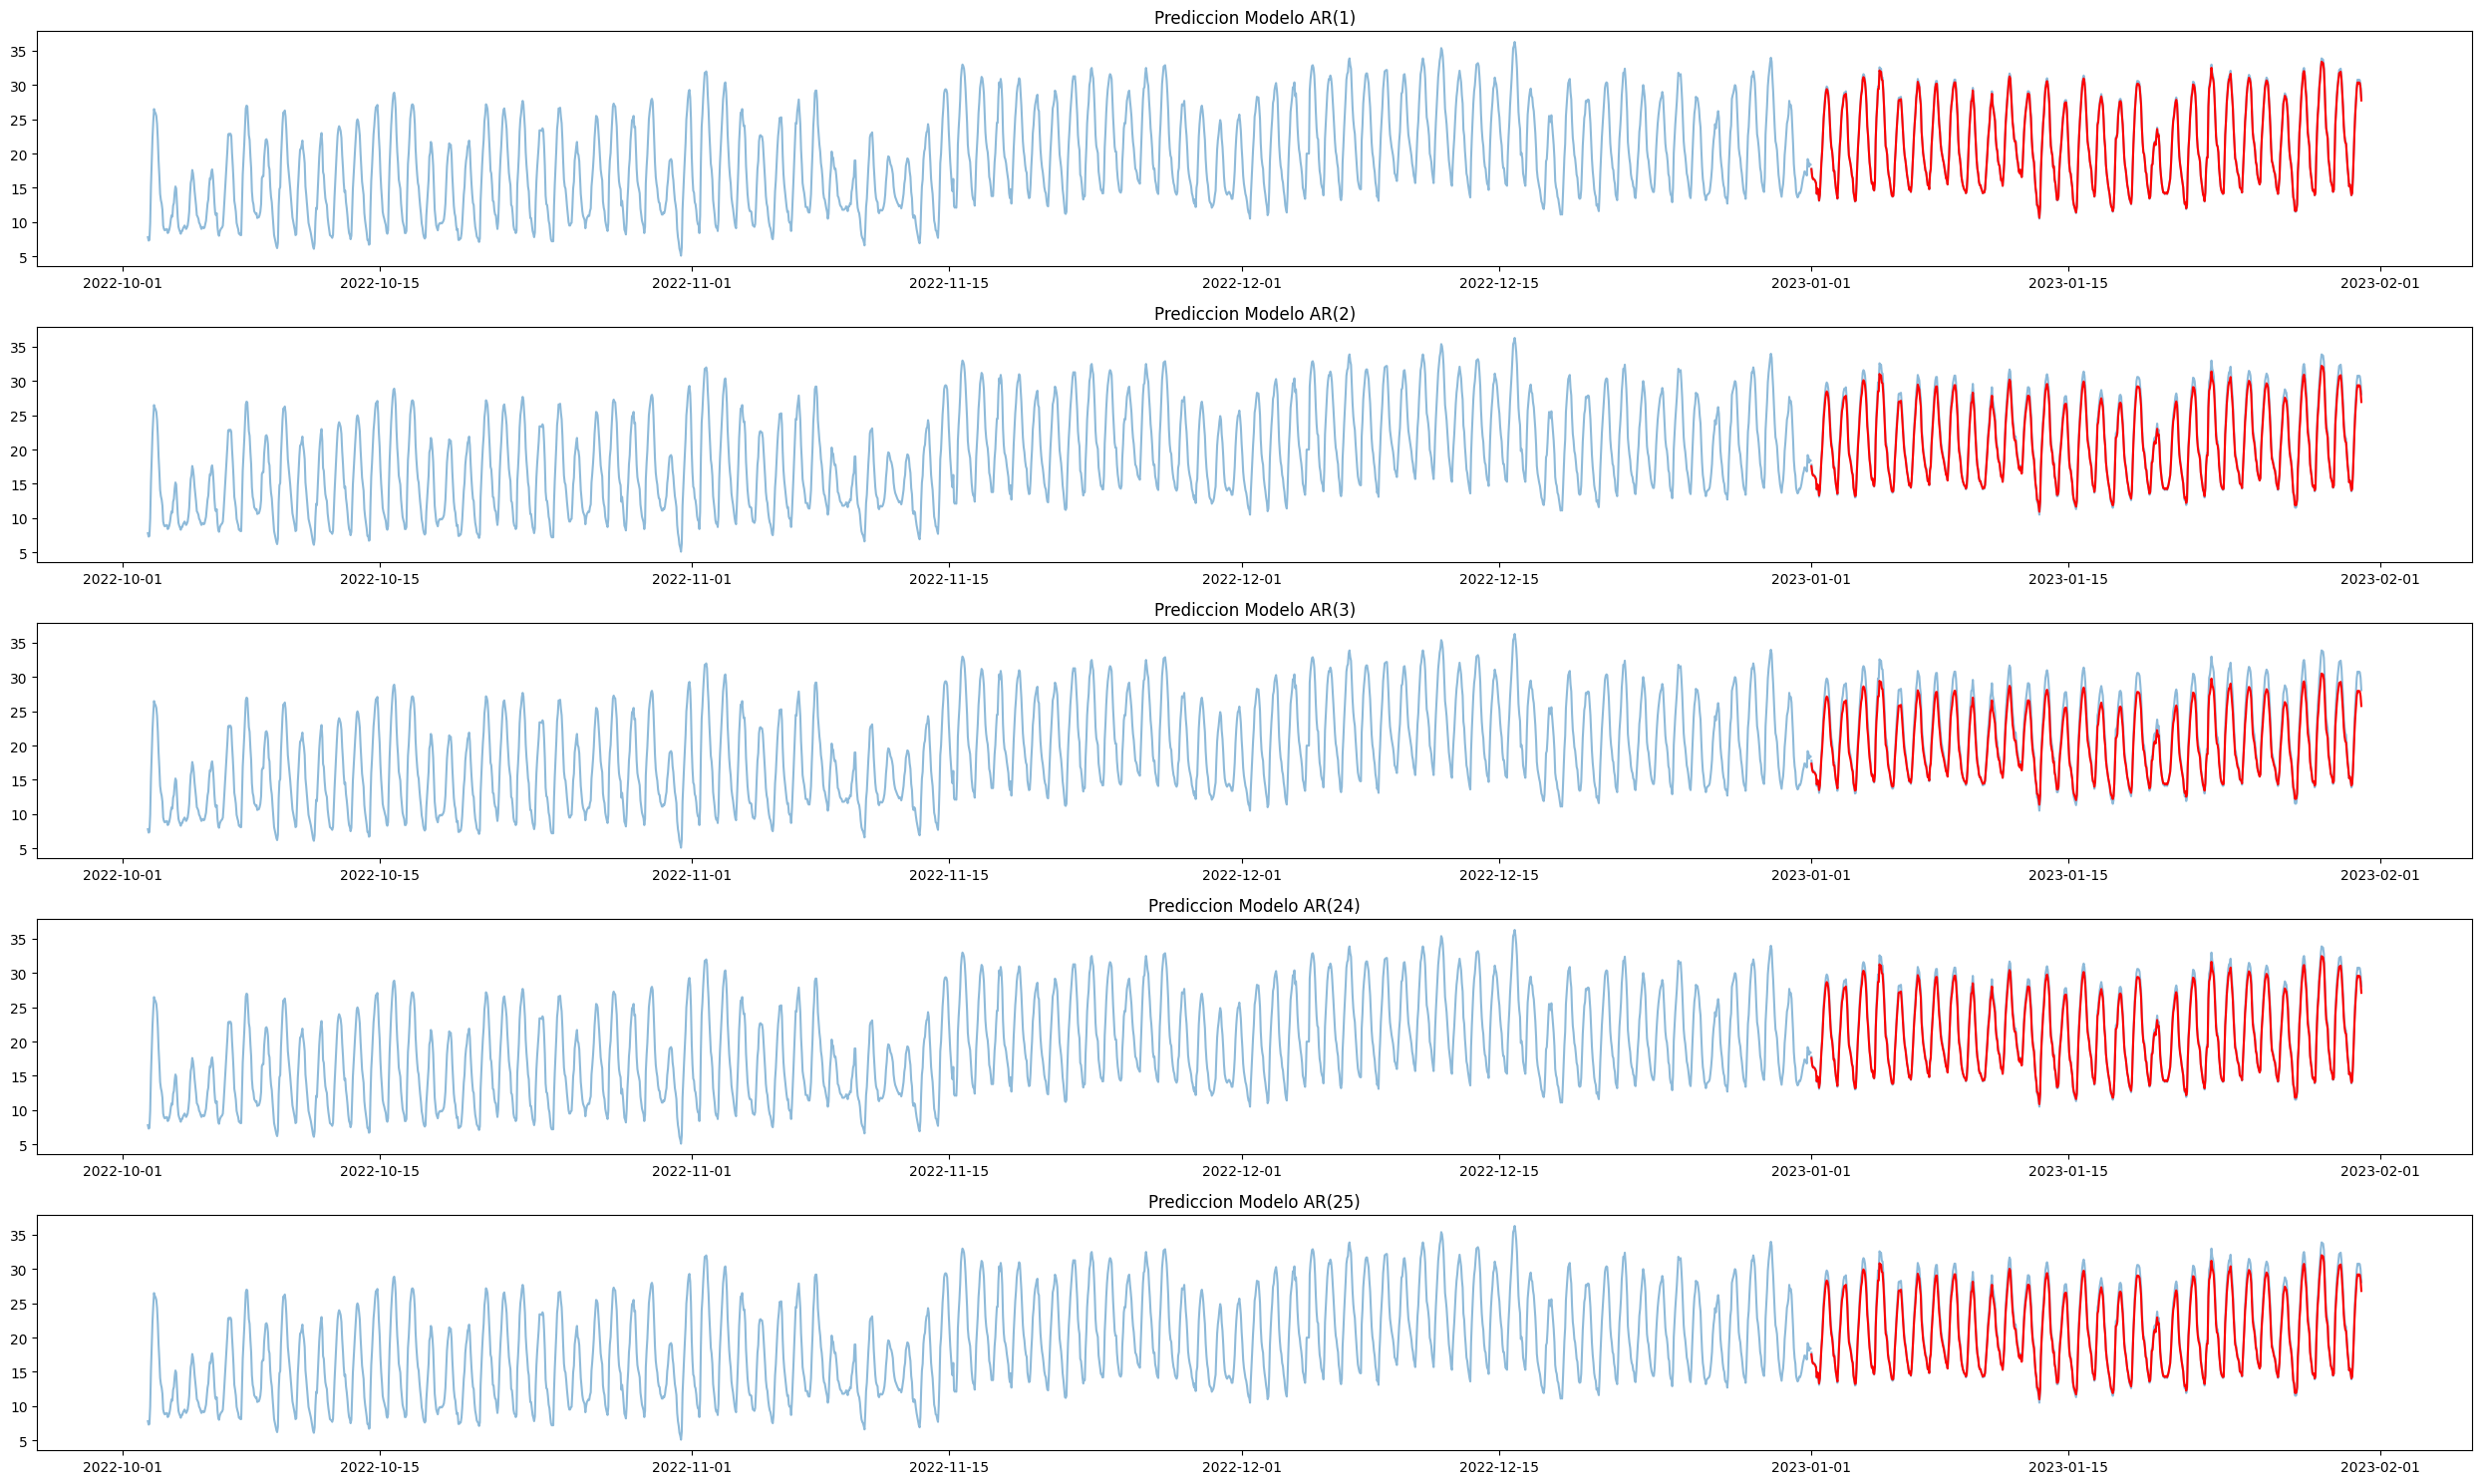

In [24]:
fig, ax = plt.subplots(5,1, figsize=(25,15))
k=0
for m in models:
    ax[k].plot(df_temp_train.iloc[-3*30*24:]['time'], df_temp_train.iloc[-3*30*24:]['Ts_Valor'], color='#1f77b4', alpha=0.5)
    ax[k].plot(df_temp_test.iloc[:30*24]['time'], df_temp_test.iloc[:30*24]['Ts_Valor'], color='#1f77b4', alpha=0.5)
    ax[k].plot(df_temp_test.iloc[:30*24]['time'], m[1].predict(pd.DataFrame({'y_lagged': df_temp_test.iloc[:30*24]['Ts_Valor']})), color='r')
    ax[k].set_title(f'Prediccion Modelo AR({m[0]})')
    k+=1
plt.tight_layout()

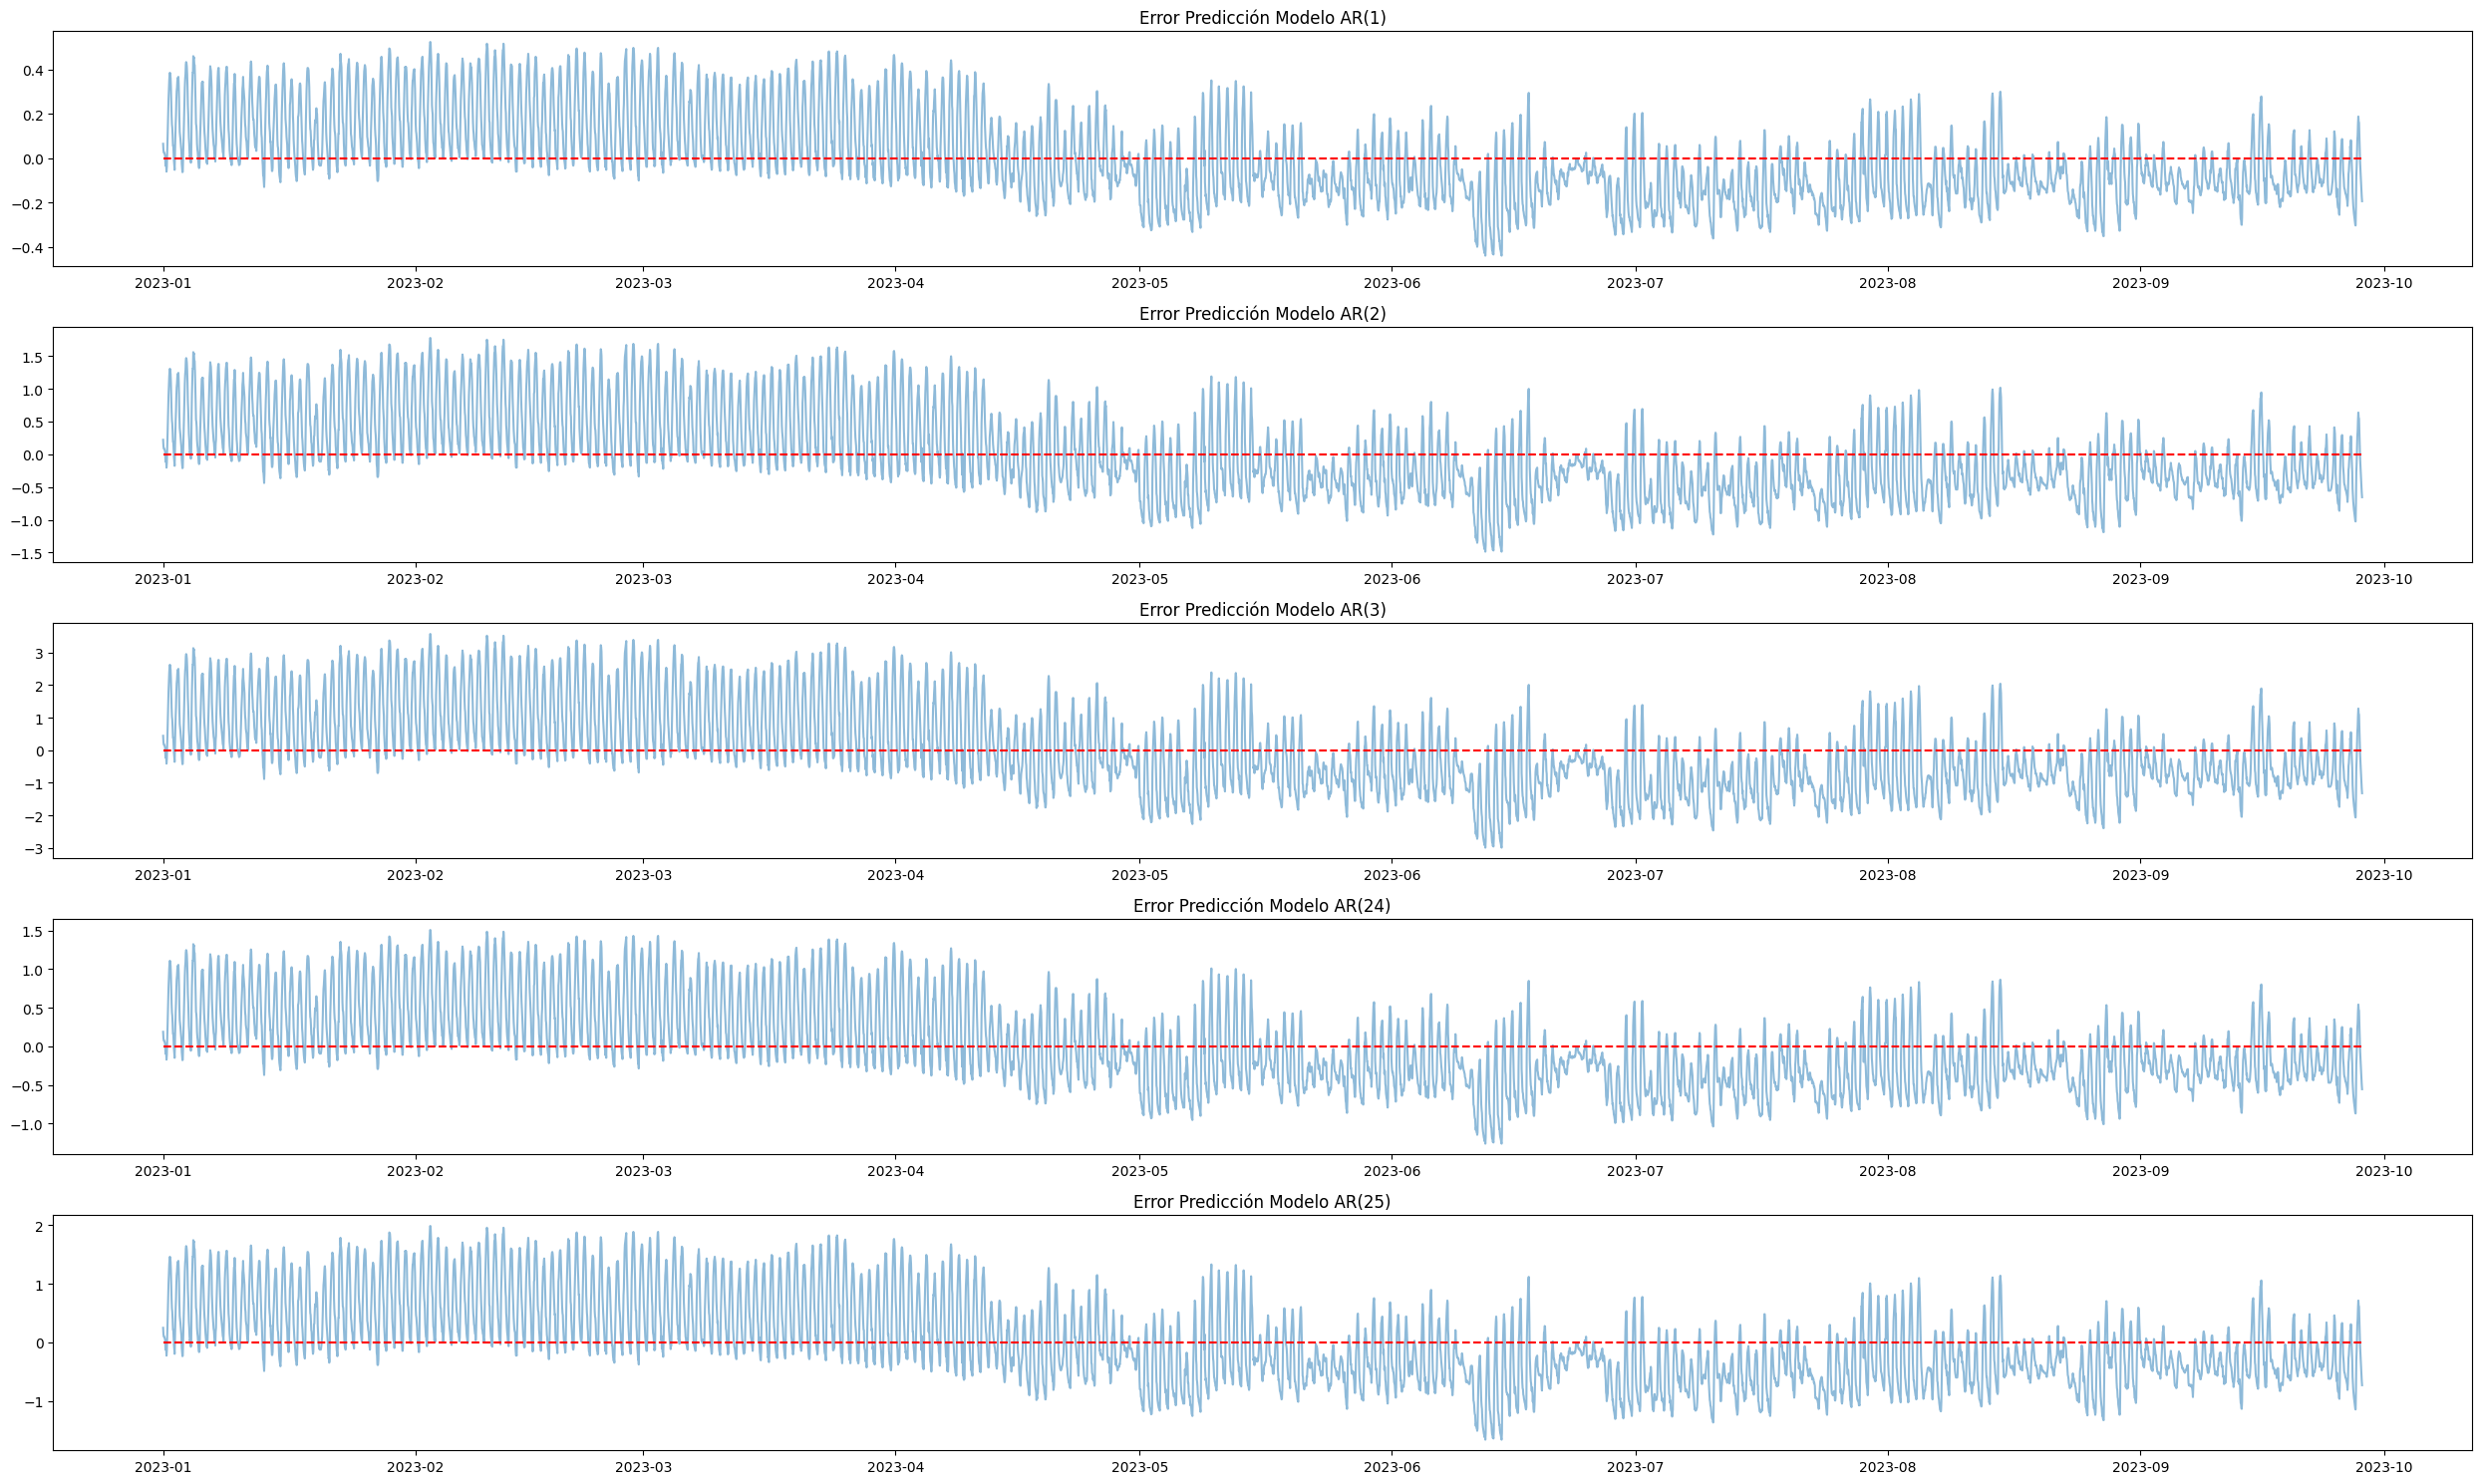

In [25]:
fig, ax = plt.subplots(5,1, figsize=(25,15))
k=0
for m in models:
    line_x = np.linspace(0, 10, len(df_temp_test['Ts_Valor']))
    ax[k].plot(df_temp_test['time'], df_temp_test['Ts_Valor'] - m[1].predict(pd.DataFrame({'y_lagged': df_temp_test['Ts_Valor']})), alpha=0.5)
    ax[k].plot([df_temp_test['time'].min(),df_temp_test['time'].max()], [0,0], color='r', linestyle='--')
    ax[k].set_title(f'Error Predicción Modelo AR({m[0]})')
    k+=1
plt.tight_layout()

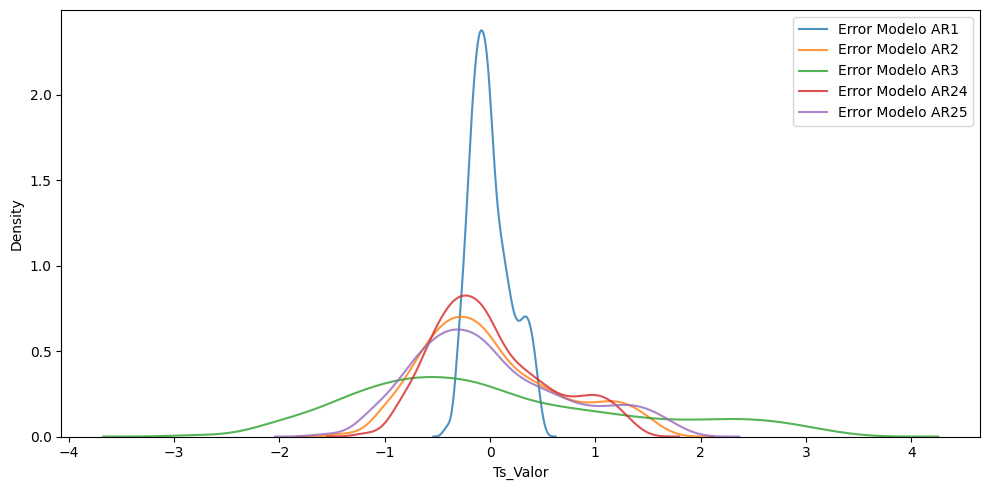

In [26]:
fig, ax = plt.subplots(1, figsize=(10,5))
for m in models:
    sns.kdeplot(df_temp_test['Ts_Valor'] - m[1].predict(pd.DataFrame({'y_lagged': df_temp_test['Ts_Valor']})), fill=False, alpha=0.8, label=f'Error Modelo AR{m[0]}')
    k+=1
plt.legend()
plt.tight_layout()

#### Modelo de Regresion lineal multiple

In [27]:
X = df_temp_train[['Ts_Valor_1h', 'Ts_Valor_2h', 'Ts_Valor_3h', 'Ts_Valor_24h', 'Ts_Valor_25h']]
y = df_temp_train['Ts_Valor']
model_multiple = LinearRegression()
model_multiple.fit(X, y)
joblib.dump(model_multiple, "../model/model_multiple.joblib")

y_pred = model_multiple.predict(X)

r2 = model_multiple.score(X, y)
n = len(X)
p = X.shape[1]
r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)
mse = mean_squared_error(y, y_pred)
results = [("multiple", r2, r2_adjusted, mse)]
results_df = pd.DataFrame(results, columns=['Order', 'R²', 'R² Adjust', 'MSE'])

# Resultados del conjunto de entrenamiento
results_df.style.set_caption("AR Model Performance - Train").background_gradient(cmap='coolwarm').format(precision=4)

,Order,R²,R² Adjust,MSE
0,multiple,0.9834,0.9833,0.9483


In [28]:
print(f'modelo con multiples lags')
print(f'Intercepto: {np.round(model_multiple.intercept_,4)}\nCoeficientes: {[np.round(c,4) for c in model_multiple.coef_]}')

modelo con multiples lags
Intercepto: 0.3966
Coeficientes: [np.float64(1.223), np.float64(-0.2336), np.float64(-0.0749), np.float64(0.5374), np.float64(-0.4778)]


In [29]:
def calculate_metrics(X: pd.DataFrame, y: pd.Series, model) -> pd.DataFrame:
    y_pred: pd.Series = model.predict(X)
    r2: float = model.score(X, y)
    n: int = len(X)
    p: int = X.shape[1]
    r2_adjusted: float = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    mse: float = mean_squared_error(y, y_pred)
    results = [("multiple", r2, r2_adjusted, mse)]
    return pd.DataFrame(results, columns=['Order', 'R²', 'R² Adjust', 'MSE'])

X = df_temp_test[['Ts_Valor_1h', 'Ts_Valor_2h', 'Ts_Valor_3h', 'Ts_Valor_24h', 'Ts_Valor_25h']]
y = df_temp_test['Ts_Valor']
results_df: pd.DataFrame = calculate_metrics(X, y, model_multiple)

results_df.style.set_caption("AR Model Performance - Test").background_gradient(cmap='coolwarm').format(precision=4)


,Order,R²,R² Adjust,MSE
0,multiple,0.9829,0.9829,0.8947


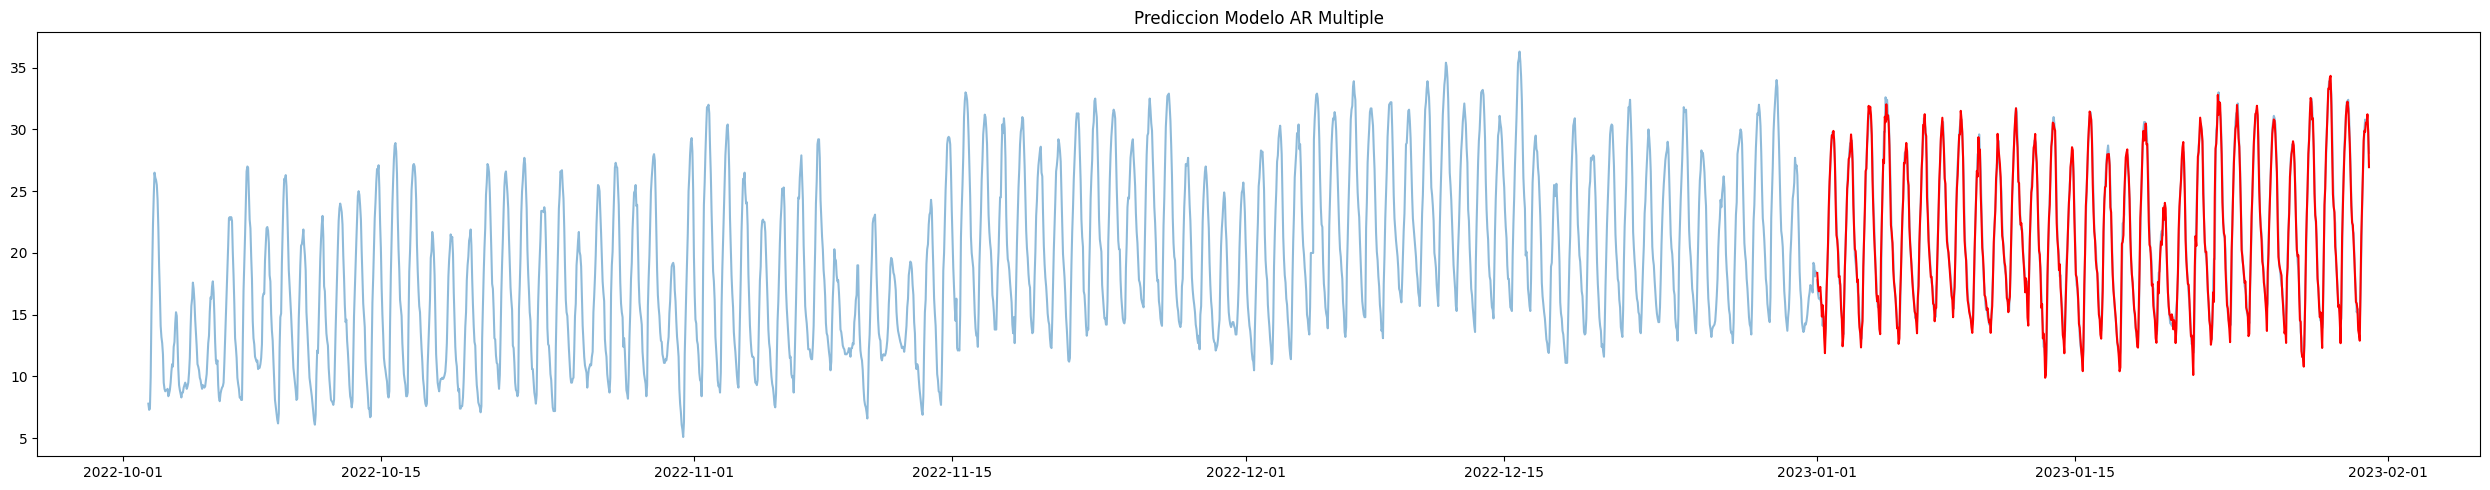

In [30]:
fig, ax = plt.subplots(1, figsize=(25,5))

ax.plot(df_temp_train.iloc[-3*30*24:]['time'], df_temp_train.iloc[-3*30*24:]['Ts_Valor'], color='#1f77b4', alpha=0.5)
ax.plot(df_temp_test.iloc[:30*24]['time'], df_temp_test.iloc[:30*24]['Ts_Valor'], color='#1f77b4', alpha=0.5)
ax.plot(df_temp_test.iloc[:30*24]['time'], model_multiple.predict(df_temp_test.iloc[:30*24][['Ts_Valor_1h', 'Ts_Valor_2h', 'Ts_Valor_3h', 'Ts_Valor_24h', 'Ts_Valor_25h']]), color='r')
ax.set_title(f'Prediccion Modelo AR Multiple')

plt.tight_layout()

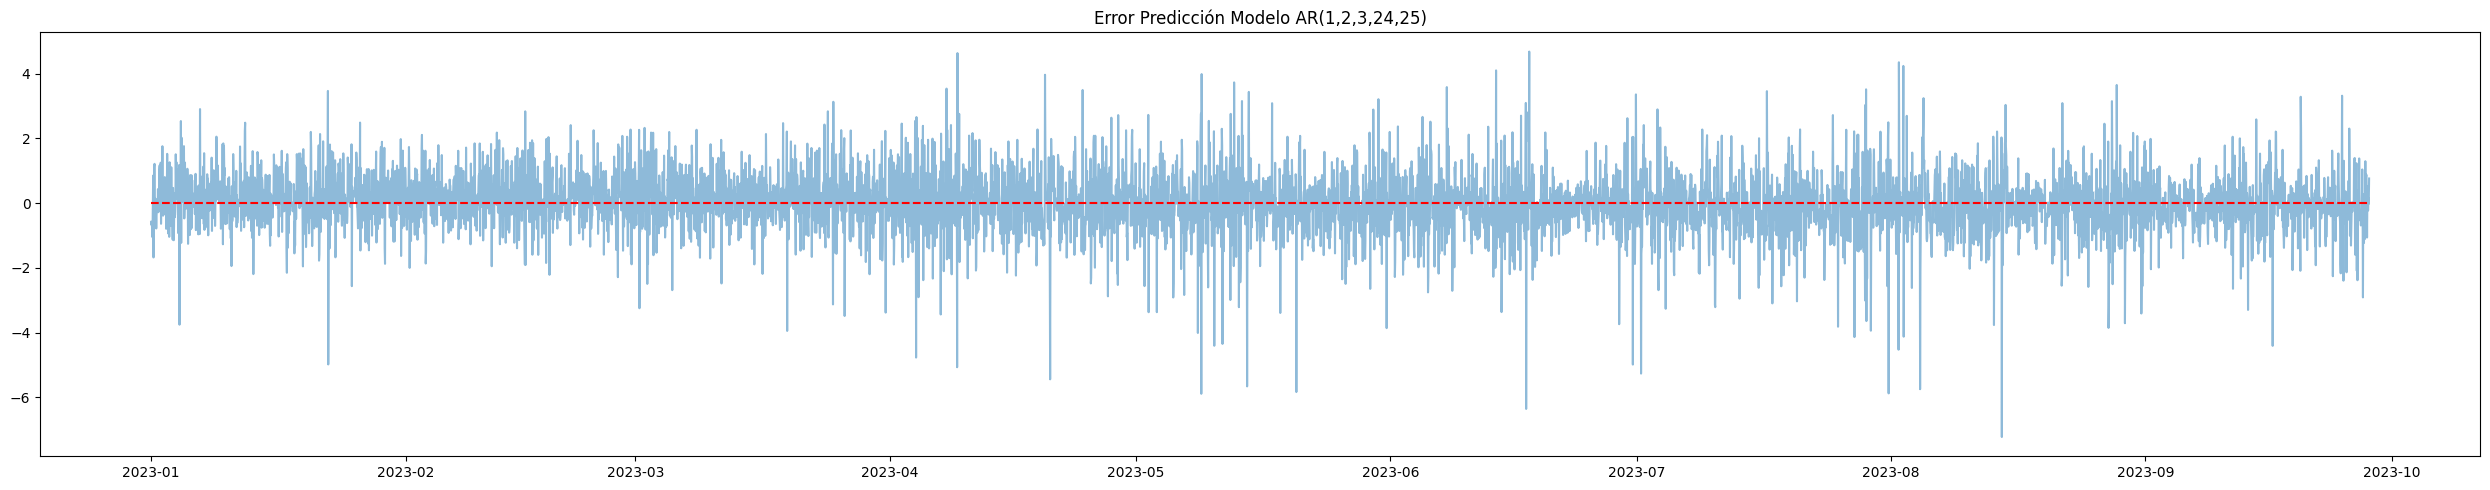

In [31]:
fig, ax = plt.subplots(1, figsize=(25,5))

line_x = np.linspace(0, 10, len(df_temp_test['Ts_Valor']))
ax.plot(df_temp_test['time'], df_temp_test['Ts_Valor'] - model_multiple.predict(df_temp_test[['Ts_Valor_1h', 'Ts_Valor_2h', 'Ts_Valor_3h', 'Ts_Valor_24h', 'Ts_Valor_25h']]), alpha=0.5)
ax.plot([df_temp_test['time'].min(),df_temp_test['time'].max()], [0,0], color='r', linestyle='--')
ax.set_title(f'Error Predicción Modelo AR(1,2,3,24,25)')

plt.tight_layout()

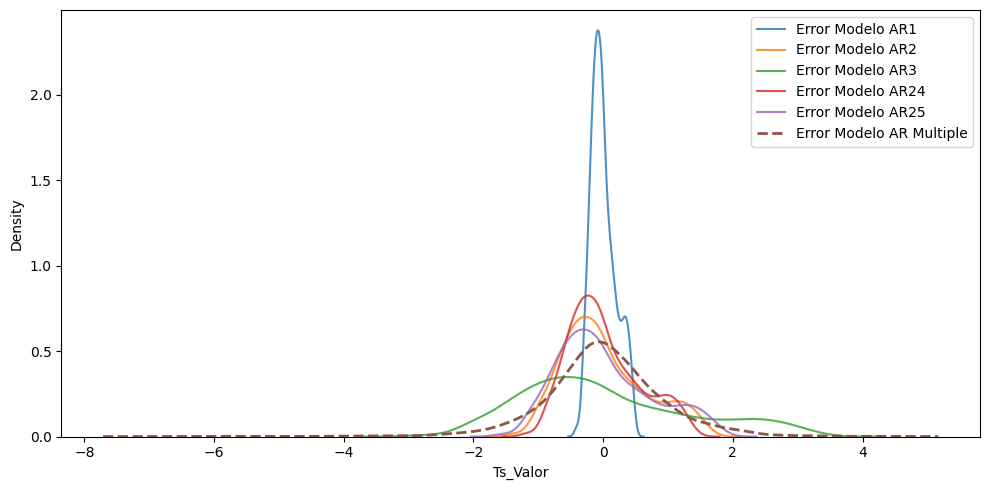

In [32]:
# Revisar y ordenar hacia arriba.
# Normaliza el error, lo cual es bueno y esperable.
# Aumenta la desviación, no se si eso es normal.
fig, ax = plt.subplots(1, figsize=(10, 5))

def calculate_error(model, df_temp_test) -> pd.Series:
    return df_temp_test['Ts_Valor'] - model.predict(pd.DataFrame({'y_lagged': df_temp_test['Ts_Valor']}))

for m in models:
    error: pd.Series = calculate_error(m[1], df_temp_test)
    sns.kdeplot(error, fill=False, alpha=0.8, label=f'Error Modelo AR{m[0]}')

error_multiple: pd.Series = df_temp_test['Ts_Valor'] - model_multiple.predict(
    df_temp_test[['Ts_Valor_1h', 'Ts_Valor_2h', 'Ts_Valor_3h', 'Ts_Valor_24h', 'Ts_Valor_25h']]
)
sns.kdeplot(error_multiple, fill=False, alpha=1.0, linewidth=2, linestyle='--', label='Error Modelo AR Multiple')

plt.legend()
plt.tight_layout()
plt.show()


### Modelos Autoregresivos (AR)

En esta sección, aplicamos modelos autoregresivos desde AR(1) hasta AR(4) sobre la variable dependiente `Ts_Valor`, utilizando regresión lineal. Los modelos AR se utilizan para predecir una variable dependiente basada en sus valores pasados, lo que es particularmente útil en series temporales.

Los modelos se evaluaron en términos de dos métricas clave:
- **R² (coeficiente de determinación)**: Indica el grado en que los valores predichos explican la variabilidad de los datos observados.
- **MSE (Error Cuadrático Medio)**: Mide la media de los errores al cuadrado entre los valores predichos y observados, donde un valor más bajo indica un mejor ajuste.

### Resultados de los Modelos AR(1) a AR(4)

| Modelo | R²  | MSE |
|--------|-----|-----|
| AR(1)  | 0.947 | 2.995 |
| AR(2)  | 0.827 | 9.828 |
| AR(3)  | 0.669 | 18.832 |
| AR(4)  | 0.500 | 28.481 |

De acuerdo con los resultados obtenidos, el modelo AR(1) presenta el mejor rendimiento en términos de R² y MSE. Esto indica que el modelo AR(1) es el más adecuado para capturar las dependencias temporales de `Ts_Valor`, mientras que los modelos con órdenes mayores no aportan mejoras significativas.


In [33]:
def ar_model(X: pd.Series, y: pd.Series, order: int) -> tuple[float, float]:
    X_lagged = pd.DataFrame({'y_lagged': y.shift(order)}).dropna()
    y_lagged = y[order:]

    model = LinearRegression()
    model.fit(X_lagged, y_lagged)

    y_pred = model.predict(X_lagged)
    r2 = model.score(X_lagged, y_lagged)
    mse = mean_squared_error(y_lagged, y_pred)
    return r2, mse

results = []
for i in range(1, 5):
    r2, mse = ar_model(df_temp[df_temp.time.dt.year<2023]['Ts_Valor'], df_temp[df_temp.time.dt.year<2023]['Ts_Valor'], i)
    results.append((i, r2, mse))

results_df = pd.DataFrame(results, columns=['Order', 'R²', 'MSE'])

# Display the results DataFrame
results_df.style.set_caption("AR Model Performance").background_gradient(cmap='coolwarm').format(precision=4)

,Order,R²,MSE
0,1,0.9474,2.9954
1,2,0.8275,9.8282
2,3,0.6694,18.8321
3,4,0.5000,28.4819
